# Библиотеки

In [ ]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    !git clone -qq https://github.com/kbayazitov/Distillation.git /tmp/repo
    !python3 -m pip install -qq /tmp/repo/src/ && rm -rf /tmp/repo

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 15.7 MB 11.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets

import os
from random import randint
import urllib
import zipfile
from sklearn import metrics

In [ ]:
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import torch
from torchvision import datasets, transforms

In [ ]:
from pylab import rcParams

rcParams['figure.figsize'] = (20.0, 10.0)
rcParams['legend.fontsize'] = 20
rcParams['axes.titlesize']=20
rcParams['axes.labelsize']=20
rcParams['font.size'] = 20
rcParams['lines.linewidth'] = 3
rcParams['axes.formatter.use_locale'] = True

In [ ]:
from mylib.train import (CNN_small, CNN_big, train_teacher, distillation_train, makeplots)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Отображение $\varphi$

In [ ]:
model=models.vgg19(pretrained=True).features

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        #Here we will use the following layers and make an array of their indices
        # 0: block1_conv1
        # 5: block2_conv1
        # 10: block3_conv1
        # 19: block4_conv1
        # 28: block5_conv1
        self.req_features= ['0','5','10','19','28'] 
        #Since we need only the 5 layers in the model so we will be dropping all the rest layers from the features of the model
        self.model=models.vgg19(pretrained=True).features[:29] #model will contain the first 29 layers
    
   
    #x holds the input tensor(image) that will be feeded to each layer
    def forward(self,x):
        #initialize an array that wil hold the activations from the chosen layers
        features=[]
        #Iterate over all the layers of the mode
        for layer_num,layer in enumerate(self.model):
            #activation of the layer will stored in x
            x=layer(x)
            #appending the activation of the selected layers and return the feature array
            if (str(layer_num) in self.req_features):
                features.append(x)
                
        return features

In [ ]:
def image_loader(path):
    image=Image.open(path)
    #defining the image transformation steps to be performed before feeding them to the model
    loader=transforms.Compose([transforms.Resize((200,200)),transforms.ToTensor()])
    #The preprocessing steps involves resizing the image and then converting it to a tensor

    image=loader(image).unsqueeze(0)
    return image.to(device,torch.float)

In [ ]:
def imshow(img):
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [ ]:
def calc_content_loss(gen_feat,orig_feat):
    #calculating the content loss of each layer by calculating the MSE between the content and generated features and adding it to content loss
    content_l=torch.mean((gen_feat-orig_feat)**2)#*0.5
    return content_l

def calc_style_loss(gen,style):
    #Calculating the gram matrix for the style and the generated image
    batch_size,channel,height,width=gen.shape

    G=torch.mm(gen.view(channel,height*width),gen.view(channel,height*width).t())
    A=torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())
        
    #Calcultating the style loss of each layer by calculating the MSE between the gram matrix of the style image and the generated image and adding it to style loss
    style_l=torch.mean((G-A)**2)#/(4*channel*(height*width)**2)
    return style_l

def calculate_loss(gen_features, orig_feautes, style_featues):
    style_loss=content_loss=0
    for gen,cont,style in zip(gen_features,orig_feautes,style_featues):
        #extracting the dimensions from the generated image
        content_loss+=calc_content_loss(gen,cont)
        style_loss+=calc_style_loss(gen,style)
    
    #calculating the total loss of e th epoch
    total_loss=alpha*content_loss + beta*style_loss 
    return total_loss

In [ ]:
model=VGG().to(device).eval() 
epoch=3
lr=0.04
alpha=8
beta=70

In [ ]:
def StyleTransfer(original_images, style_image=image_loader('style.jpg')):
    res = []
    for original_image in original_images:
        original_image = original_image.view([1,3,200,200])
        generated_image=original_image.clone().requires_grad_(True)

        #initialize the paramerters required for fitting the model

        #using adam optimizer and it will update the generated image not the model parameter 
        optimizer=optim.Adam([generated_image],lr=lr)

        #iterating
        for e in range(epoch):
            #extracting the features of generated, content and the original required for calculating the loss
            gen_features=model(generated_image)
            orig_feautes=model(original_image)
            style_featues=model(style_image)
    
            #iterating over the activation of each layer and calculate the loss and add it to the content and the style loss
            total_loss=calculate_loss(gen_features, orig_feautes, style_featues)
            #optimize the pixel values of the generated image and backpropagate the loss
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
        res.append(generated_image)    
    tensor_res = torch.stack([torch.from_numpy(np.array(i.cpu().detach())) for i in res])
    return tensor_res.to(device).view([-1,3,200,200])

# Выборка

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar -xvf 'imagenette2.tgz'
DATA_DIR = 'imagenette2'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'val')

In [ ]:
preprocess = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Resize([200,200])])

ImNet_train = datasets.ImageFolder(TRAIN_DIR, transform=preprocess)
ImNet_test = datasets.ImageFolder(TEST_DIR, transform=preprocess)

ImNet_big, ImNet_small = torch.utils.data.random_split(ImNet_train,
                                                       [8469, 1000],
                                                       generator=torch.Generator().manual_seed(SEED))

In [ ]:
#X = []
#Y = []
#for x, y in tqdm(ImNet_big):
#    x = x.to(device).view([1,3,200,200])
#    im = StyleTransfer(x).view([3,200,200])
#    X.append(im)
#    Y.append(y)

#X_train = torch.stack([torch.from_numpy(np.array(i.cpu().detach())) for i in X])
#y_train = torch.stack([torch.from_numpy(np.array(i)) for i in Y])
#X_train = X_train.reshape((-1, 3, 200, 200)).float()
#ImNet_big_styled = torch.utils.data.TensorDataset(X_train, y_train)

#torch.save(ImNet_big_styled, 'drive/MyDrive/data/ImNet_big_styled.pt')

In [ ]:
ImNet_big_styled = torch.load('drive/MyDrive/data/ImNet_big_styled.pt')

In [ ]:
print('length of train dataset = {} \n'.format(len(ImNet_train)), 
      'length of test dataset = {} \n'.format(len(ImNet_test)),
      'length of big part = {} \n'.format(len(ImNet_big)),
      'length of big styled part = {} \n'.format(len(ImNet_big)),
      'length of small part = {}'.format(len(ImNet_small)))

length of train dataset = 9469 
 length of test dataset = 3925 
 length of big part = 8469 
 length of big styled part = 8469 
 length of small part = 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


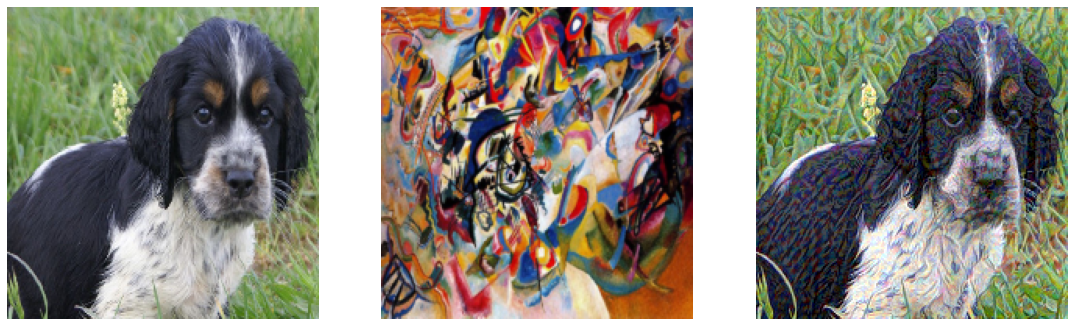

In [ ]:
image = ImNet_train[1001][0].to(device).view([1,3,200,200])
style = image_loader('style.jpg')
styled_image = StyleTransfer(image).view([1,3,200,200])

fig, gs = plt.figure(figsize=(19,10)), gridspec.GridSpec(1, 3)

images = [image, style, styled_image]

ax = []

for i in range(3):
    ax.append(fig.add_subplot(gs[i]))
    im = images[i][0].cpu().detach().numpy()
    ax[i].imshow(np.transpose(im, (1,2,0)))
    ax[i].axis('off')

plt.show()

# Дистилляция на выборке с преобразованием стиля

## Без отображения

In [ ]:
Student = CNN_small()
Student.to(device)
_ = Student.train()
list_of_test_acc, list_of_test_losses, _, _= distillation_train(Student, ImNet_small, ImNet_test, input_shape=[-1,3,200,200],
                                                                epochs=15)

In [ ]:
Teacher = CNN_big()
Teacher.to(device)
_ = Teacher.train()
train_teacher(Teacher, ImNet_big, ImNet_test, input_shape=[-1,3,200,200], epochs=15)

In [ ]:
Student = CNN_small()
Student.to(device)
_ = Student.train()
list_of_test_acc_dist, list_of_test_losses_dist, _, _ = distillation_train(Student, ImNet_small, ImNet_test,
                                                                           input_shape=[-1,3,200,200], epochs=15,
                                                                           teacher=Teacher)

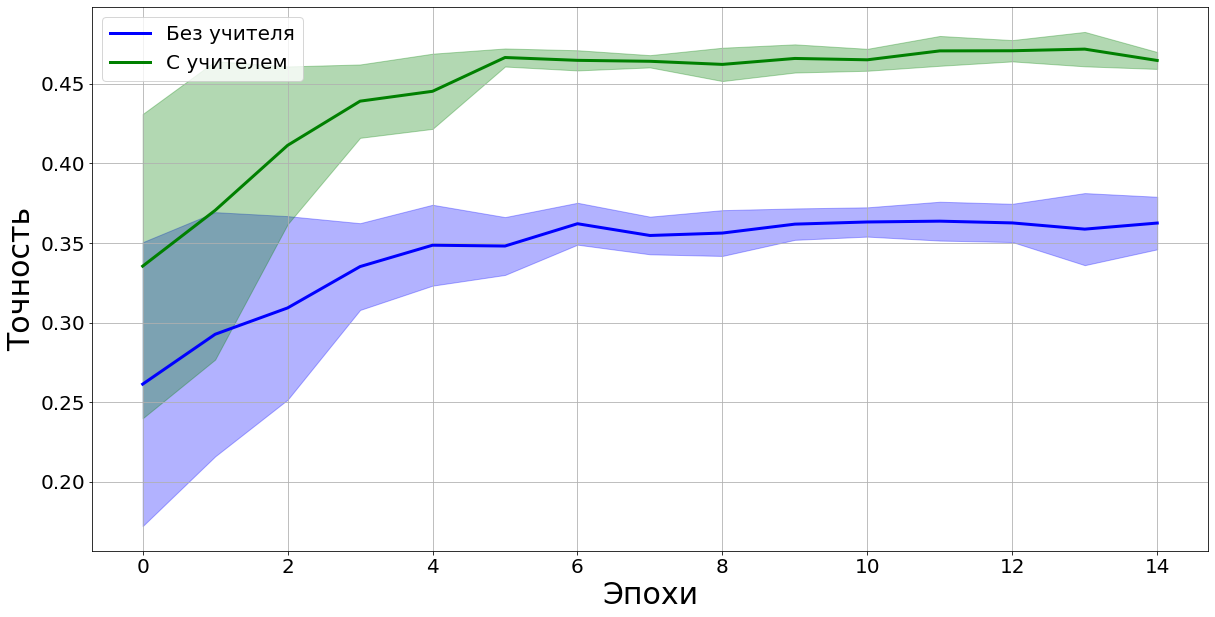

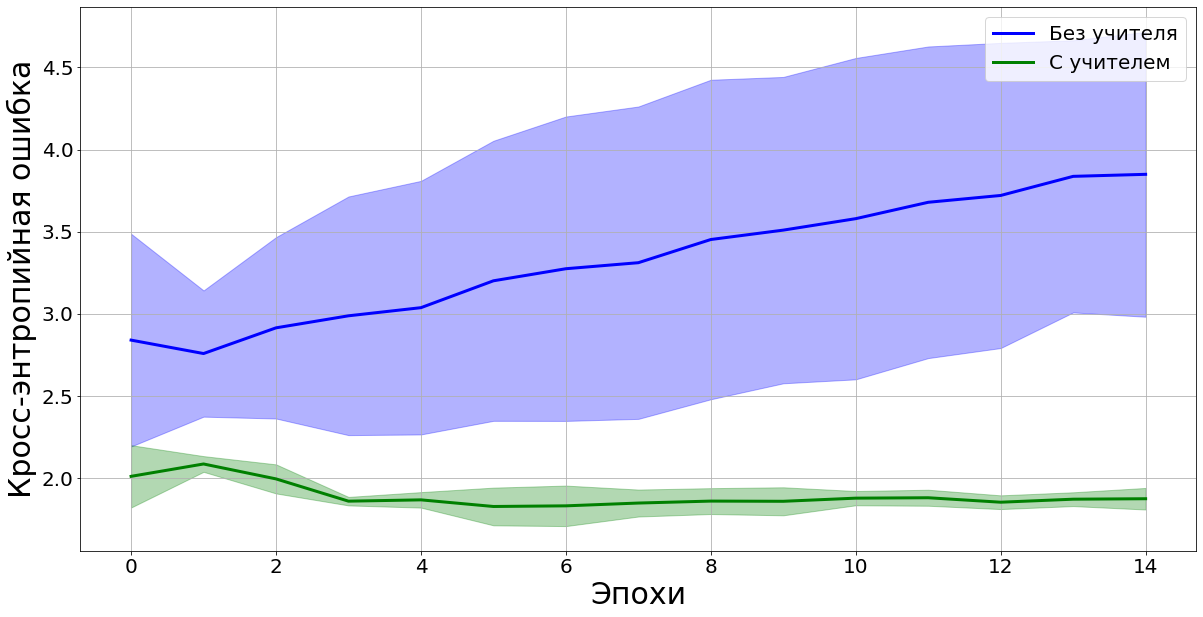

In [ ]:
labels = ['Без учителя', 'С учителем']
makeplots(losses=[list_of_test_losses, list_of_test_losses_dist],
          labels=labels,
          accs=[list_of_test_acc, list_of_test_acc_dist])

In [ ]:
print('Accuracy of student without teacher={}+-{}'.format(round(np.array(list_of_test_acc).mean(0)[-1], 3),
                                                          round(np.array(list_of_test_acc).std(0)[-1],3)))
print('Loss of student without teacher={}+-{}'.format(round(np.array(list_of_test_losses).mean(0)[-1], 3),
                                                      round(np.array(list_of_test_losses).std(0)[-1],3)))
print('Accuracy of student with teacher={}+-{}'.format(round(np.array(list_of_test_acc_dist).mean(0)[-1],3),
                                                       round(np.array(list_of_test_acc_dist).std(0)[-1],3)))
print('Loss of student with teacher={}+-{}'.format(round(np.array(list_of_test_losses_dist).mean(0)[-1],3),
                                                   round(np.array(list_of_test_losses_dist).std(0)[-1],3)))
print('Integral criterion without teacher={}+-{}'.format(round(np.trapz(np.array(list_of_test_losses).mean(0), np.arange(0,15)), 3),
                                                       round(np.trapz(np.array(list_of_test_losses).std(0), np.arange(0,15)), 3)))
print('Integral criterion with teacher={}+-{}'.format(round(np.trapz(np.array(list_of_test_losses_dist).mean(0), np.arange(0,15)), 3),
                                                  round(np.trapz(np.array(list_of_test_losses_dist).std(0), np.arange(0,15)), 3)))

Accuracy of student without teacher=0.363+-0.017
Loss of student without teacher=3.849+-0.866
Accuracy of student with teacher=0.465+-0.005
Loss of student with teacher=1.876+-0.066
Integral criterion without teacher=46.615+-11.498
Integral criterion with teacher=26.488+-0.996


## С отображением

In [ ]:
Student = CNN_small().to(device)
Teacher = CNN_big().to(device)

_ = Teacher.train()
train_teacher(Teacher, ImNet_big_styled, ImNet_test, input_shape=[-1,3,200,200], epochs=15)

_ = Student.train()
list_of_test_acc_style, list_of_test_losses_style, _, _ = distillation_train(Student, ImNet_small, ImNet_test,
                                                                             input_shape=[-1,3,200,200], epochs=15,
                                                                             teacher=Teacher,
                                                                             phi=lambda x: StyleTransfer(x))

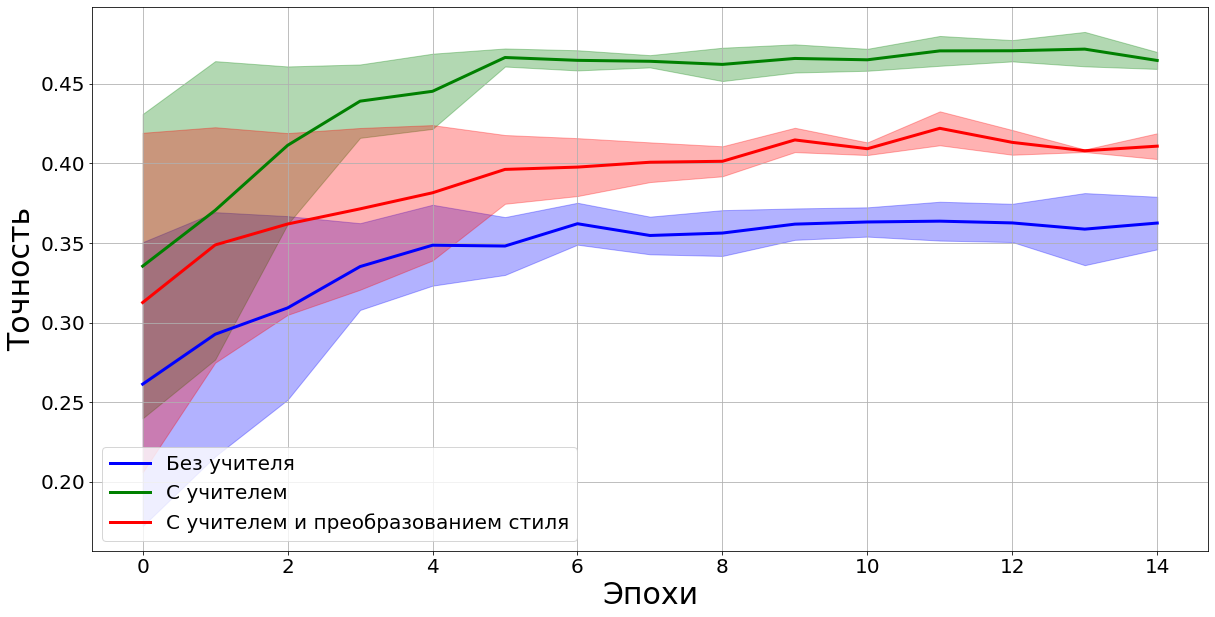

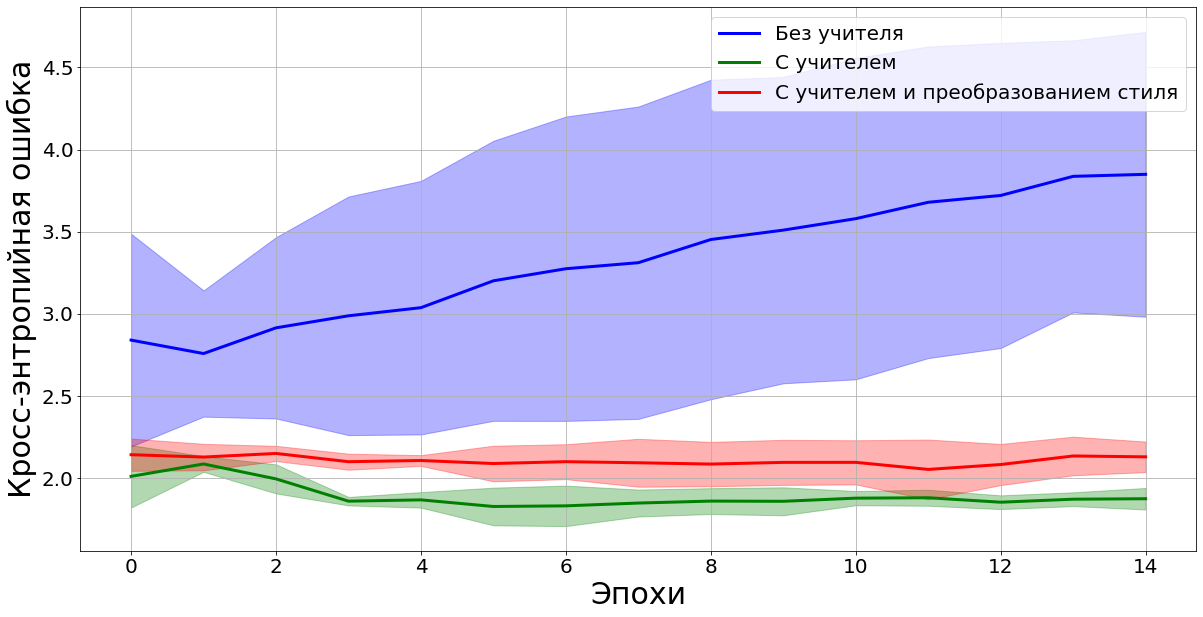

In [ ]:
labels = ['Без учителя', 'С учителем', 'С учителем и преобразованием стиля']

makeplots(losses=[list_of_test_losses, list_of_test_losses_dist, list_of_test_losses_style],
          labels=labels,
          accs=[list_of_test_acc, list_of_test_acc_dist, list_of_test_acc_style])

In [ ]:
print('Accuracy of student with styled teacher={}+-{}'.format(round(np.array(list_of_test_acc_style).mean(0)[-1],3),
                                                       round(np.array(list_of_test_acc_style).std(0)[-1],3)))
print('Loss of student with styled teacher={}+-{}'.format(round(np.array(list_of_test_losses_style).mean(0)[-1],3),
                                                   round(np.array(list_of_test_losses_style).std(0)[-1],3)))
print('Integral criterion with styled teacher={}+-{}'.format(round(np.trapz(np.array(list_of_test_losses_style).mean(0), np.arange(0,15)), 3),
                                                  round(np.trapz(np.array(list_of_test_losses_style).std(0), np.arange(0,15)), 3)))

Accuracy of student with styled teacher=0.411+-0.008
Loss of student with styled teacher=2.131+-0.093
Integral criterion with styled teacher=29.476+-1.495
